In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston 
from importlib import reload
reload(heston)
from heston import calibrate_heston, get_tick
import datetime
from scipy import stats as sps
from typing import Union
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
raw = pd.HDFStore('../datasets/eth-20230224.h5','r').get("/eth")

CPU times: user 21.3 s, sys: 3.09 s, total: 24.3 s
Wall time: 26.2 s


In [3]:
def process_data(data):
    # only options
    df = data.copy()
    df = df[(df["instrument"].str.endswith("C")) | (df["instrument"].str.endswith("P"))].sort_values("dt")
    df["type"] = np.where(df["instrument"].str.endswith("C"), "call", "put")
    
    perpetuals = data[data["instrument"].str.endswith("PERPETUAL")][["dt", "price"]].copy()
    perpetuals = perpetuals.rename(columns = {"price": "underlying_price"}).sort_values("dt")
    
    def get_strike(x):
        return int(x.split("-")[2])
    
    def get_expiration(x):
        return x.split("-")[1]
    

    df["strike_price"] = df["instrument"].apply(get_strike)
    df["expiration"] = df["instrument"].apply(get_expiration)
    
    def unix_time_millis(dt):
        epoch = datetime.datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds() * 1000_000)
    
    def get_normal_date(s):
        """Function to convert date to find years to maturity"""
        monthToNum = {
            "JAN": 1,
            "FEB": 2,
            "MAR": 3,
            "APR": 4,
            "MAY": 5,
            "JUN": 6,
            "JUL": 7,
            "AUG": 8,
            "SEP": 9,
            "OCT": 10,
            "NOV": 11,
            "DEC": 12,
        }

        full_date = s.split("-")[1]
        try:
            day = int(full_date[:2])
            month = monthToNum[full_date[2:5]]
        except:
            day = int(full_date[:1])
            month = monthToNum[full_date[1:4]]
        
        year = int("20" + full_date[-2:])
        exp_date = datetime.datetime(year, month, day)
        return unix_time_millis(exp_date)
    
    df["dt"] = pd.to_datetime(df["dt"])
    perpetuals["dt"] = pd.to_datetime(perpetuals["dt"])
    
    df = pd.merge_asof(df, perpetuals, on="dt",
                       tolerance=pd.Timedelta('7 minutes'),
                       direction='nearest',)
    
    df["timestamp"] = df["dt"].apply(unix_time_millis)
    df["expiration"] = df["instrument"].apply(get_normal_date)
    df = df.rename(columns = {"price": "mark_price"})
    
    
    return df


In [4]:
%%time
start = process_data(raw)


CPU times: user 49.4 s, sys: 17.9 s, total: 1min 7s
Wall time: 1min 17s


In [5]:
df = start.copy()
# df = df[(df["timestamp"]>=1672000000000000) & (df["timestamp"]<=1672800000000000)]
df

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.90,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.90,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.90,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.90,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.90,1669036104511000
...,...,...,...,...,...,...,...,...
7498621,2023-02-24 07:13:46.716,0.0300,ETH-24FEB23-1700-P,put,1700,1677196800000000,1651.85,1677222826716000
7498622,2023-02-24 07:13:47.576,0.2975,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222827576000
7498623,2023-02-24 07:13:51.208,0.0015,ETH-24FEB23-1650-P,put,1650,1677196800000000,1651.85,1677222831208000
7498624,2023-02-24 07:13:55.748,0.2980,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222835748000


In [ ]:
df_s = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df_s = df_s.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df_s.symbol]
df_s = df_s[ind].reset_index(drop=True)
# df = df[df["expiration"] == 1680249600000000]
# after expiration
# df = df[df["timestamp"] > 1669881600000000]
# df = df[df["timestamp"]<=1669928620213347.0]

df = df_s.copy()
df = df[df["expiration"].isin([1680249600000000, 1688112000000000, 
                               1672387200000000, 1674806400000000, 1669968000000000, 
                               1695974400000000, 1677225600000000])]

# See params dynamic

In [ ]:
# calibrate base
number_of_dots = 20
timestamps_hm = []
names = ["kappa", "nu_bar", "sigma", "rho", "nu0"]
params_all = []
params_nu0 = []
errors_all = []
errors_nu0 = []

a = np.float64(1.0)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(1.0)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])
print("Optimize first params with random start once")
calibrated_params_all, first_error_all = calibrate_heston(df = df, 
                                                          start_params = start_params, calibration_type = "all")
calibrated_params_nu0, first_error_nu0 = calibrate_heston(df = df, 
                                                          start_params = start_params, calibration_type = "nu0")
print("all first calibrated", calibrated_params_all)
print("nu0 first calibrated", calibrated_params_nu0)

# Get ticks with similar distnce from available data
timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all = calibrate_heston(df = df, start_params = calibrated_params_all, 
                                                            timestamp = timestamp, calibration_type = "all")
        print("All calibrated:", calibrated_params_all)
        # save all calib_params
        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        
        
        calibrated_params_nu0, error_nu0 = calibrate_heston(df = df, start_params = calibrated_params_nu0, 
                                                            timestamp = timestamp, calibration_type = "nu0")
        print("nu0 calibrated:", calibrated_params_nu0)
        # save nu0 calib params
        params_nu0.append(calibrated_params_nu0)
        errors_nu0.append(error_nu0)
        
        
        print("    ")
        # save timestame that could calibrate
        timestamps_hm.append(timestamp)
            
    except ValueError:
        # if could not calibrate, start next calibration with prev params
        print(f"Could not calibrate LM on {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
#         calibrated_params_all = params_all[-1]
#         try:
#             calibrated_params_nu0 = params_nu0[-1]
#         except:
#             calibrated_params_nu0 = params_all[-1]
        
    except IndexError:
        print(f"Could not calibrate nu0 {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
#         calibrated_params_all = params_all[-1]
#         try:
#             calibrated_params_nu0 = params_nu0[-1]
#         except:
#             calibrated_params_nu0 = params_all[-1]
        
    except ZeroDivisionError:
        print(f"Zero dev jacobian on {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
#         calibrated_params_all = params_all[-1]
#         try:
#             calibrated_params_nu0 = params_nu0[-1]
#         except:
#             calibrated_params_nu0 = params_all[-1]

    

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_nu0 = np.array(params_nu0).T

In [ ]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0][:-1])
axs[0, 0].plot(timestamps_hm, params_nu0[0])
axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")

axs[0, 1].plot(timestamps_hm, params_all[1][:-1])
axs[0, 1].plot(timestamps_hm, params_nu0[1])
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")

axs[1, 0].plot(timestamps_hm, params_all[2][:-1], label = "all")
axs[1, 0].plot(timestamps_hm, params_nu0[2], label = "nu0")
axs[1, 0].set_title(r"$\sigma$ - vol of vol")

axs[1, 1].plot(timestamps_hm, params_all[3][:-1])
axs[1, 1].plot(timestamps_hm, params_nu0[3])
axs[1, 1].set_title("ρ -rho")

axs[2, 0].plot(timestamps_hm, params_all[4][:-1])
axs[2, 0].plot(timestamps_hm, params_nu0[4])
axs[2, 0].set_title(r"$\nu_0$ - initial variance")

axs[2, 1].plot(timestamps_hm, errors_all[:-1])
axs[2, 1].plot(timestamps_hm, errors_nu0)
axs[2, 1].set_title("error")



# for i in range(3):
#     for j in range(2):
#         for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
#             if i == j == 0:
#                 axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)
#                 pass


plt.figlegend() 
fig.suptitle("Heston params dynamic")

plt.show()

# Vol smile

In [6]:
stamp = df.sample(1).iloc[0].timestamp
# print(df.timestamp.max() - df.timestamp.min())
print(stamp)

1675519551945000


In [8]:
needed_stamp = 1673321843011000
a = np.float64(1.0)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(1.0)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])

pars_all, err_all, C_all = calibrate_heston(df = df, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "all")

pars_nu0, err_nu0, C_nu0 = calibrate_heston(df= df, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "nu0")

pars_and_nu_bar, err_and_nu_bar, C_and_nu_bar = calibrate_heston(df= df, start_params = start_params, 
                                                                 timestamp = needed_stamp,
                                calibration_type= "nu0_and_nu_bar")




/Users/zugzvangg/Desktop/Projects/crypto-calibration/Heston/heston.py:1174: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/Users/zugzvangg/Desktop/Projects/crypto-calibration/Heston/heston.py:1185: RuntimeWarning: divide by zero encountered in double_scalars
  dv = PriceError / Vega
/Users/zugzvangg/Desktop/Projects/crypto-calibration/Heston/heston.py:1174: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/Users/zugzvangg/Desktop/Projects/crypto-calibration/Heston/heston.py:1174: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/Users/zugzvangg/Desktop/Projects/crypto-calibration/Heston/heston.py:1185: RuntimeWarning: divide by zero encountered in double_scalars
  dv = PriceError / Vega
/Users/zugzvangg/Desktop/Projects/crypto-calibration/Heston/heston.py:1174: RuntimeWarnin

In [9]:
print("All:")
print(pars_all)
print(err_all)

All:
[88.73164388  0.30031139 18.59609144 -0.09452175  0.4703659 ]
0.10336662438207314


In [10]:
print("All:")
print(pars_nu0)
print(err_nu0)


All:
[24.39987653  0.43330381 10.78904626 -0.08834885  0.33858138]
0.1391736797125196


In [11]:
print("All:")
print(pars_and_nu_bar)
print(err_and_nu_bar)

All:
[ 2.17780633  1.14538754  8.23324266 -0.09681105  0.33858138]
0.14389913435165225


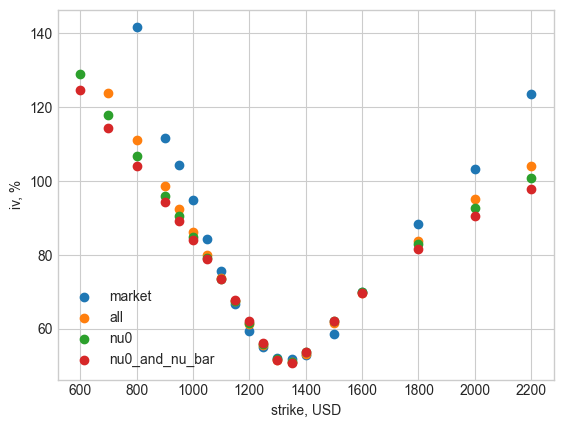

In [13]:
exp = C_all.sample(1).expiration.iloc[0]
C_sing_exp_all = C_all[C_all["expiration"] == exp]
C_sing_exp_nu0 = C_nu0[C_nu0["expiration"] == exp]
C_sing_exp_and_nu_bar = C_and_nu_bar[C_and_nu_bar["expiration"] == exp]

plt.scatter(C_sing_exp_all["strike_price"], C_sing_exp_all["market_iv"], label = "market")
plt.scatter(C_sing_exp_all["strike_price"], C_sing_exp_all["calibrated_iv"], label = "all")
plt.scatter(C_sing_exp_nu0["strike_price"], C_sing_exp_nu0["calibrated_iv"], label = "nu0")
plt.scatter(C_sing_exp_and_nu_bar["strike_price"], C_sing_exp_and_nu_bar["calibrated_iv"], label = "nu0_and_nu_bar")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()

In [ ]:
# single_instr = df[df["instrument"] == df.sample(1).instrument.iloc[0]]
# plt.plot(single_instr["dt"], single_instr["mark_price"])
# plt.plot(df["dt"], df["underlying_price"])